# Matrix Product State Test

In [16]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Construct quantum circuit
circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure([0,1], [0,1])

# Select the AerSimulator from the Aer provider
simulator = AerSimulator(method='matrix_product_state')

# Run and get counts, using the matrix_product_state method
tcirc = transpile(circ, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
counts

{'11': 509, '00': 515}

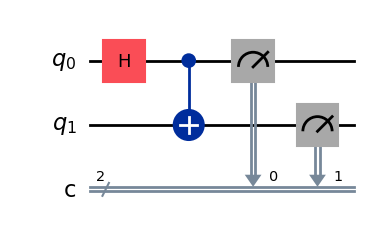

In [4]:
circ.draw('mpl')

# Creating Circuit

In [5]:
def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list


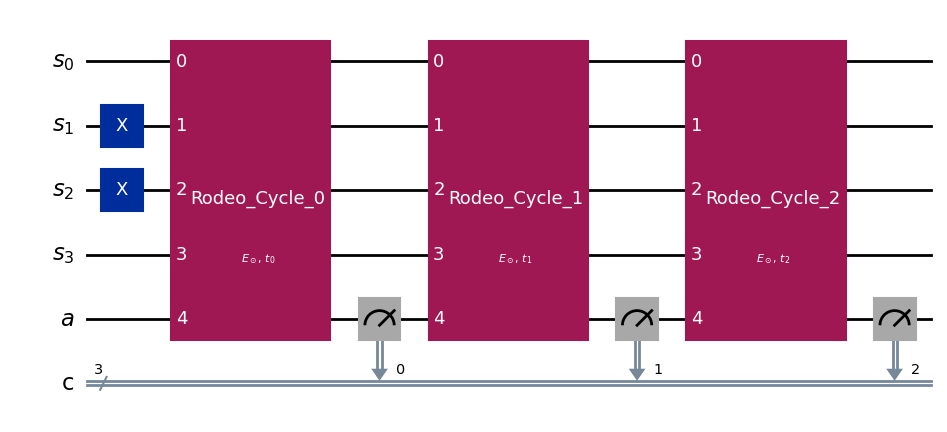

In [17]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

def create_super_iterations(time_sample: float, iterations: int):
    times_list = np.zeros(iterations + 1)
    
    time = time_sample
    
    for i in range(0, iterations+1):
        time /= 2  # Halve the time each iteration
        times_list[i] = time
    
    return times_list

# Define circuit parameters
num_sites = 2
J_input = 4.0
U_input = 1.0

# Initialize cycling parameters
cycles = 3
iterations = 0

# Initialize Qiskit parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
si_time = [Parameter(fr'$st_{j}$') for j in range(cycles * iterations)]
steps = 5

# Create registers and circuit
classical = ClassicalRegister(cycles * (1 + iterations), 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with alternating rodeo cycles and super iterations
classical_idx = 0
super_idx = 0 

for j in range(cycles):
    rodeo_gate = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label=fr'Rodeo_Cycle_{j}'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[classical_idx])
    classical_idx += 1 

    # Add super iteration cycles with si_time
    for k in range(iterations):
        rodeo_gate_si = rodeo_cycle(num_sites=num_sites, J_value=J_input, U_value=U_input, t=si_time[super_idx], r=steps, targ=target)
        circuit.append(rodeo_gate_si.to_gate(label=fr'SI_Rodeo_Cycle_{j}_{k}'), range(num_sites * 2 + 1))
        circuit.measure(aux, classical[classical_idx])
        classical_idx += 1 
        super_idx += 1 

# Draw the circuit
circuit.draw('mpl')



In [7]:
def generate_superiteration_times(tsamples, superiterations, si_time):

    # Validate the size of si_time
    if len(si_time) < len(tsamples) * superiterations:
        raise ValueError("Insufficient si_time parameters for the given cycles and superiterations.")
    
    superiteration_parameter_binds = {}
    

    for i in range(len(tsamples)):

        superiteration_times = []
        time = tsamples[i]
        for _ in range(superiterations):
            time /= 2
            superiteration_times.append(time)
        
        for j in range(superiterations):
            si_index = i * superiterations + j
            superiteration_parameter_binds[si_time[si_index]] = superiteration_times[j]
    
    return superiteration_parameter_binds

In [23]:
# Enumerate scan energies
energymin = -10
energymax = 10
stepsize = 0.1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 1

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

def get_allzeros_probability(counts, num_qubits):
    """
    Calculate probability of all zeros state from counts dictionary
    
    Args:
        counts (dict): Dictionary with binary strings as keys and counts as values
        num_qubits (int): Number of qubits in the circuit
        
    Returns:
        float: Probability of measuring all zeros state
    """
    # Create the all-zeros bitstring for this number of qubits
    allzeros = '0' * num_qubits
    
    # Get total number of shots
    total_shots = sum(counts.values())
    
    # Get counts for all-zeros state, default to 0 if not present
    allzeros_count = counts.get(allzeros, 0)
    
    # Return probability
    return allzeros_count / total_shots

# Main simulation loop
data = []  # Will store probabilities for each energy

# Loop through energy list
for i in range(len(targetenergies)):
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}
    print("Executing for Target Energy:", targ_energy)
    
    # Store probabilities for this energy
    energy_probabilities = []
    
    # Do multiple time resamples for this energy
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)

        superiteration_parameters = generate_superiteration_times(tsamples, superiterations=iterations, si_time=si_time)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace=False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace=False)
        circuit3 = circuit2.assign_parameters(superiteration_parameters, inplace=False)
        
        # Run simulation
        simulator = AerSimulator(method='matrix_product_state')
        tcirc = transpile(circuit3, simulator)
        result = simulator.run(tcirc).result()
        counts = result.get_counts(0)
        
        # Get probability of all-zeros state for this run
        prob = get_allzeros_probability(counts, num_qubits=len(next(iter(counts))))  # gets number of qubits from first bitstring
        energy_probabilities.append(prob)
    
    # Average the probabilities for this energy value
    avg_probability = sum(energy_probabilities) / len(energy_probabilities)
    data.append(avg_probability)

# Now data contains the average probability of all-zeros for each energy value
# You can directly plot this against targetenergies
values_list = data  # No need for additional processing

print(len(values_list))
print(len(targetenergies))

        

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


Number of target energies: 200
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-10.0)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.899497487437186)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.798994974874372)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.698492462311558)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.597989949748744)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.49748743718593)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.396984924623116)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.296482412060302)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.195979899497488)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-9.095477386934673)}
Executing for Target Energy: {Parameter($E_\odot$): np.float64(-8.99497487437186)}
Executing for Target Energy: {Parameter($E_\odot$): np.float

NameError: name 'plt' is not defined

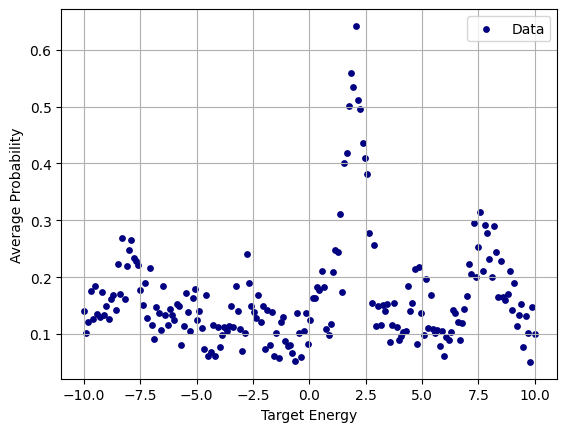

In [24]:
import matplotlib.pyplot as plt

plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()